# Final Project: Wood and Trees

For this project, I will be taking two distinct approaches: one will use a classification tree, and the other will use a convolutional neural network in order to solve this problem of image inpainting.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [477]:
leavespic = mpimg.imread('./Leaves_Masked.jpg')
woodpic = mpimg.imread('./Wood_Masked.jpg')

## Model 1: Classification Tree

The first thing we have to do is preprocess our data, which we can split into two steps: first, we make sure that the inside square is completely white by reassigning those pixels the correct values. Zooming into the picture shows us that there is some color bleeding into the white square, and this could potentially cause a problem when it comes to edge cases during our data formatting. 

In [125]:
leavespicwhite = leavespic.copy()
woodpicwhite = woodpic.copy()

for i in range(300, 601):
    for j in range(300, 601):
        leavespicwhite[i][j] = [255,255,255]
        woodpicwhite[i][j] = [255,255,255]

leavespicfloat = leavespicwhite/255
woodpicfloat = woodpicwhite/255

for i in range(300, 601):
    for j in range(300, 601):
        leavespicfloat[i][j] = np.array([1,1,1])
        woodpicfloat[i][j] = np.array([1,1,1])

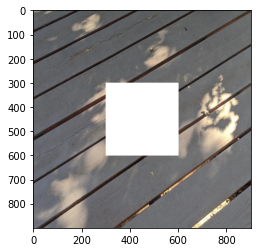

In [126]:
imgplot = plt.imshow(woodpicwhite, origin='upper')
plt.show()

Next, we need to turn this continuous problem of dealing with RGB uint8 values into a discrete one, so as to make it a suitable input for the classification tree. My initial thought was to do this by assigning regions of the RGB [0,255]<sup>3</sup> space to a couple of colors. After a bit more research, however, I came across the **HSV** color space, which can be represented as a cylinder rather than a cube like RGB. HSV seperates colors by hue, saturation, and brightness, and so this makes assigning values to colors much easier.

In [35]:
import matplotlib.colors as matcol

In [127]:
hsvleaves = matcol.rgb_to_hsv(leavespicfloat)
hsvwood = matcol.rgb_to_hsv(woodpicfloat)
hsvwood[0][16]

array([0.0787037 , 0.16744186, 0.84313725])

We can define this mapping manually like so:
* Black: V<0.3
* White: S<0.2
* Red: H is [0,25] or [345,360]
    * Brown: and V<0.7
* Orange: H is [25,50]
* Yellow: H is [50,70]
* Green: H is [70,160]
    * Dark Green: and V<0.7
    * Light Green: and V>0.7
* Light blue: H is [160,190]
* Blue: H is [190, 260]
* Purple: H is [260, 300]
* Pink: H is [300, 345]

While we might not use the entirety of this mapping (there doesn't seem to be any purple or pink pixels in either image), it is good to account for all possible values and mitigate any conversion problems we might have.

Next, we need to consider the input and output space of the model. My first idea was to simply use the 8 or 24 pixels directly surrounding any one given pixel, much like how a convolution deals with pixels. However, when it comes to this problem of inpainting, we have to decide an approach to take first, and then see what our input space would be accordingly. For me, I decided to "paint" the white square one pixel at a time from left to right. By going one pixel at a time, we can guarantee that our classification tree isn't outputting multiple pixels at a time which would undoubtedly add unneeded complexity to the code. Classification trees are usually not equipped to deal with multiple outputs at once, and the effort needed to modify the model to do so would most likely not be worth the increase in visual quality, if any at all. 

I also chose to paint from left to right out of convenience as well, which brings up the concept of bootstrapping, where we base our predictions of a column on previously predicted pixels. The further right on the square the model goes, the error from the previous column of outputted pixels becomes compounded. While this is a concern and might make the final product asymmetric in quality, we can mitigate this by trying to iterate from right to left on the image as well at the same time.

Given that these are our decisions for approaching the problem, the choice of input data becomes clearer. My initial thought of immediately surrounding pixels would not work, as our testing data (the white square pixels) would have information not represented by the training data, namely, the white pixels on the right side for each pixel in the square. Instead, I decided to choose a 5x5 array of pixels directly to the left of any one given pixel. That is, for a pixel I<sub>i,j</sub>, the 25 features would be all I<sub>i,j</sub> such that -5<=i<=5 and -2<=j<=2. The reasoning for not choosing a smaller array, like 3x2, is that visual data doesn't carry well at such small scales. A few off-colored pixels in a vast region of green or brown might create strangely colored streaks in the final product, so considering a slightly larger array would help to mitigate that problem as it carries a bit more surrounding visual data. At the same time, too large of an array, say 25x25, would capture color at the macro scale but would potentially fail to generate details well. 

One initial concern I had when deciding that my data should be purely to the left of a pixel was that it would render data augmentation, such an rotation or flipping of the images, pointless. The data to the left of a pixel may carry different visual significance to that pixel as the pixels to the right, or above, etc, and the model could contradict itself. However, each individual array of pixels does not carry enough important visual data on their own to make this a concern at all, and so our "left" data could also be used to have the model travel right to left. Additionally, just from the original image we could procure a dataset on the order of magnitude of 900<sup>2</sup> = 81000 datapoints, so lack of training data is not a concern anyway. 

In [145]:
leavescolors = [ [0]*900 for i in range(900)]
woodcolors = [ [0]*900 for i in range(900)]

In [139]:
def hsvtocolor(arr): # takes in vector of 3 values and outputs a string
    h = arr[0]*360
    s = arr[1]
    v = arr[2]
    if v<=0.3: return "black"
    if v<=0.75 and s<=0.2: return "gray"
    if s<=0.2: return "white"
    # guarantee v>0.3 and s>0.2
    if (h>=0 and h<=25) or (h>=345 and h<=360):
        if v<=0.7: return "brown"
        else: return "red"
    if h>25 and h<=50: return "orange"
    if h>50 and h<=70: return "yellow"
    if h>70 and h<=160:
        if v<=0.7:
            if s>0.5: return "deep dark green"
            else: return "pale dark green"
        if v>0.7:
            if s>0.5: return "deep light green"
            else: return "pale light green"
    if h>160 and h<=190: return "light blue"
    if h>190 and h<=260: return "blue"
    if h>260 and h<=300: return "purple"
    if h>300 and h<=345: return "pink"

In [140]:
# function that outputs a representative rgb color array for each color string to be used later
def colortorgb(color):
    rgbarray = []
    if color == "black": rgbarray = [0.1, 0.1, 0.1]
    if color == "gray": rgbarray = [0.48, 0.47, 0.43]
    if color == "white": rgbarray = [0.9,0.9,0.9]
    if color == "brown": rgbarray = [0.43,0.15,0.07]
    if color == "red": rgbarray = [0.8,0.02,0.03]
    if color == "orange": rgbarray = [0.87,0.45,0.06]
    if color == "yellow": rgbarray = [0.87,0.78,0.06]
    if color == "pale light green": rgbarray = [0.56,0.84,0.5]
    if color == "deep light green": rgbarray = [0.3,0.8,0.23]
    if color == "pale dark green": rgbarray = [0.41,0.51,0.31]
    if color == "deep dark green": rgbarray = [0.27,0.51,0]
    if color == "light blue": rgbarray = [0.32,0.786,0.709]
    if color == "blue": rgbarray = [0.32,0.439,0.941]
    if color == "purple": rgbarray = [0.6,0.32,0.941]
    if color == "pink": rgbarray = [0.94,0.324,0.663]
    return rgbarray


In [146]:
for i in range(0, 900):
    for j in range(0, 900):
        leavescolors[i][j] = hsvtocolor(hsvleaves[i][j])
        woodcolors[i][j] = hsvtocolor(hsvwood[i][j])

In [182]:
sorted(np.unique(leavescolors, return_counts=True)[1], reverse=True)

[243400,
 219119,
 113385,
 107402,
 44806,
 43490,
 16223,
 15801,
 3647,
 1119,
 1081,
 303,
 224]

To see how well this discretization works, lets take the original images and convert them using the colortorgb function to see if the converted images look similar to the original.

In [148]:
xd = np.zeros(shape=(900,900,3))
xd2 = np.zeros(shape=(900,900,3))

lnp = np.array(leavescolors)
wnp = np.array(woodcolors)

for i in range(900):
    for j in range(900):
        xd[i][j] = colortorgb(lnp[i][j])
        xd2[i][j] = colortorgb(wnp[i][j])

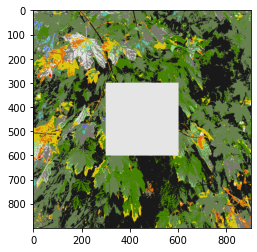

In [151]:
imgplot = plt.imshow(xd, origin='upper')
plt.show()

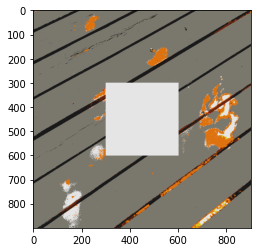

In [821]:
imgplot = plt.imshow(xd2, origin='upper')
plt.show()

While it is a very rough mapping, this picture looks decent. Now we can create our training/testing dataset.

In [450]:
leavescolorsdf = pd.DataFrame(columns=[f'x{i}' for i in range(1,26)]+['y'])
woodcolorsdf = pd.DataFrame(columns=[f'x{i}' for i in range(1,26)]+['y'])

In [452]:
def createdata(colorsarray, targetdf):
    for i in range(6, 900, 100):
        for j in range(2, 897, 100):
            if (i<600 and i>300) or (j<600 and j>300): continue
            targetdf.loc[len(targetdf.index)] = [
                colorsarray[i-5][j-2], colorsarray[i-5][j-1], colorsarray[i-5][j], colorsarray[i-5][j+1], colorsarray[i-5][j+2],
                colorsarray[i-4][j-2], colorsarray[i-4][j-1], colorsarray[i-4][j], colorsarray[i-4][j+1], colorsarray[i-4][j+2],
                colorsarray[i-3][j-2], colorsarray[i-3][j-1], colorsarray[i-3][j], colorsarray[i-3][j+1], colorsarray[i-3][j+2],
                colorsarray[i-2][j-2], colorsarray[i-2][j-1], colorsarray[i-2][j], colorsarray[i-2][j+1], colorsarray[i-2][j+2],
                colorsarray[i-1][j-2], colorsarray[i-1][j-1], colorsarray[i-1][j], colorsarray[i-1][j+1], colorsarray[i-1][j+2],
                colorsarray[i][j]
                ]
            print(i,j)

As this function would take extremely long to run for every pixel on the entire image, we can use a step size of 100 to just get a representative sample of the pixels of the image: having a datapoint for every single pixel would lead to a massive amount of redundancy in the dataset. While a step size of 100 might seem massive compared to the amount of data we are using as our features, it is a necessary tradeoff to be made for runtime. As this model needs to produce 300<sup>2</sup> outputs, each individual pixel calculation needs to run extremely fast for the image to be filled in within a reasonable runtime. The overall shapes in the full image do not change much at all between each new pixel, so using a step size of 100 in the horizontal and vertical directions still gives us a good sample of the full data.

In [453]:
createdata(leavescolors, leavescolorsdf)
createdata(woodcolors, woodcolorsdf)

6 2
6 102
6 202
6 602
6 702
6 802
106 2
106 102
106 202
106 602
106 702
106 802
206 2
206 102
206 202
206 602
206 702
206 802
606 2
606 102
606 202
606 602
606 702
606 802
706 2
706 102
706 202
706 602
706 702
706 802
806 2
806 102
806 202
806 602
806 702
806 802
6 2
6 102
6 202
6 602
6 702
6 802
106 2
106 102
106 202
106 602
106 702
106 802
206 2
206 102
206 202
206 602
206 702
206 802
606 2
606 102
606 202
606 602
606 702
606 802
706 2
706 102
706 202
706 602
706 702
706 802
806 2
806 102
806 202
806 602
806 702
806 802


In [790]:
def traintestsplit(df):
    m,n = df.shape
    dfxtrain = df.iloc[0:int(0.9*m), 0:-1]
    dfytrain = df.iloc[0:int(0.9*m), -1]
    dfxtest = df.iloc[int(0.9*m):, 0:-1]
    dfytest = df.iloc[int(0.9*m):, -1]

    dftrain = df.iloc[0:int(0.9*m), :]
    dftest = df.iloc[int(0.9*m):, :]

    return dftrain, dftest

In [455]:
leavescolorsdf = leavescolorsdf.sample(frac=1).reset_index(drop=True) # shuffles datapoints
woodcolorsdf = woodcolorsdf.sample(frac=1).reset_index(drop=True) # shuffles datapoints

In [472]:
leavescolorsdf.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x17,x18,x19,x20,x21,x22,x23,x24,x25,y
0,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow
1,black,black,black,black,black,black,black,black,black,black,...,black,black,black,black,black,black,black,black,black,black
2,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,...,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,deep dark green,pale dark green,deep dark green
3,black,black,black,pale dark green,pale dark green,black,black,black,pale dark green,pale dark green,...,pale dark green,black,pale dark green,pale dark green,black,black,pale dark green,pale dark green,pale dark green,pale dark green
4,black,black,yellow,gray,gray,black,pale dark green,gray,gray,pale dark green,...,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green
5,deep dark green,pale dark green,black,black,black,pale dark green,pale dark green,black,black,black,...,black,pale dark green,black,black,black,black,deep dark green,black,black,black
6,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,...,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green
7,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,...,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,pale dark green,deep dark green
8,deep dark green,black,black,deep dark green,deep dark green,black,black,deep dark green,deep dark green,deep dark green,...,deep dark green,deep dark green,pale dark green,deep dark green,deep dark green,deep dark green,deep dark green,pale dark green,deep dark green,deep dark green
9,gray,gray,light blue,light blue,light blue,gray,gray,gray,light blue,light blue,...,light blue,light blue,light blue,gray,light blue,light blue,light blue,light blue,gray,light blue


When considering a classification tree, however, we run into the signficant problem that each feature can be more than 2 classes; each pixel can be one of 14 colors. This means that our tree would not be binary, but would rather have (at most) 14 children, exponentially increasing the runtime of both creating these trees and running them on new data. There are a couple of options here: one would be to simply wait a long time for this tree to run and hope that the notebook doesn't crash. Another would be to assign each color a number and build a regression tree instead, calculating the splits for each color-number pair as well. A third option would be to run 14 trees simultaneously on 14 different datasets, one for each color, to output what a pixel could be. We now consider each option.  

In [457]:
print(np.unique(leavescolors, return_counts=True)[1])
print(np.unique(woodcolors, return_counts=True)[1])

[219119   1119    224 113385   1081  58946   3647  15801 243400  16223
    303  91946  44806]
[ 47821      5   8112 706124  28254      8     11    264  18228   1173]


We can see that the pixels do not span all 14 colors, and that some colors are more likely to show up than others. Regardless, however, even taking an optimistic view of a maximum of 6 colors, this is a massive leap in computation from a binary tree and would most likely not be feasible.

For the second option, creating this color-number mapping imbues an irrelevant 1 dimensional structure onto what is essentially a 3 dimensional space. There isn't any solid criteria to determine whether one color should be a higher number than another, especially as we have colors that span a cylindrical space (HSV) and that are darker/more saturated/have different hues from others. Additionally, using a regression tree here would render the classification preprocessing we did earlier pointless. 

The third option allows us to have multiple binary trees that are efficient to compute and retains the spirit of a classification solution. The group of trees is most likely not going to produce a contradictory output (one tree says a pixel should be red, another says yellow), but for this case we can just safely choose randomly between the positive outputs, as they are most likely going to be "similar" colors.

In [459]:
colors = ["black", "gray", "white", "brown", "red", "orange", "yellow", "pale light green", "deep light green", 
        "pale dark green", "deep dark green", "light blue", "blue", "purple", "pink"]

leavescolordict = {}
woodcolordict = {}
for color in colors:
    leavescolordict["{}df".format(color)] = leavescolorsdf.where(leavescolorsdf==color).replace(np.nan, -1).replace(color, 1)
    woodcolordict["{}df".format(color)] = woodcolorsdf.where(woodcolorsdf==color).replace(np.nan, -1).replace(color, 1)

Now that our preprocessing and data collection is done, we can create the Classification Tree class. Because we made the decision to keep the data structured as binary, the majority of the code is going to be the same as previous assignments. The calculated loss/error here for the tree is simply to count up misclassifications on the training/testing data and divide by the total number of datapoints in the dataset (average misclassifications). The lower the loss, the more likely it is that newly classified pixels match the visual patterns of the other parts of the image (the training data), so this measure of loss makes sense for the problem. The training algorithm for my classification tree is the ID3 algorithm, where we cycle through each feature in the dataset and split the node on whichever feature has the highest information gain, then run the algorithm again on each child recursively.

In [365]:
class ClassificationTree:
    def __init__(self, numpdf, left=None, right=None): 
        self.df = numpdf # self.df is a numpy array NOT pandas dataframe
        self.left = left
        self.right = right
        self.bestfeature = -1

    def split(self):
        if self.df[(self.df[:,-1]==-1),:].shape[0] == 0 or self.df[(self.df[:,-1]==1),:].shape[0] == 0:
            return (None, None) # pure node, y is either all -1 or +1

        best = self.findbestfeature()
        leftdata = self.df[self.df[:,best] == -1]
        rightdata = self.df[self.df[:,best] == 1]
        return (leftdata, rightdata)

    def findbestfeature(self):
        bestfeatureIG = -1
        for featurenumber in range(self.df.shape[1]-1): # number of columns (0-14)
            if self.informationgain(featurenumber) > bestfeatureIG:
                bestfeatureIG = self.informationgain(featurenumber)
                self.bestfeature = featurenumber
        
        return self.bestfeature


    def informationgain(self, featurenumber):
        return self.entropyY() - self.entropyYgivenX(featurenumber)
        

    def entropyY(self):
        ent = 0
        for i in [-1,1]:
            probi = self.df[(self.df[:,-1]==i),:].shape[0] / self.df.shape[0] 
            ent += probi * np.log2(probi)

        return ent*-1


    def entropyYgivenX(self, featurenumber):
        ent = 0
        # featurenumber = int(feature[-1]) - 1 # just turning the feature string into an index. (ex: 'x1' -> 0)
        for i in [-1,1]: # iterate over x
            numberofxiequalsx = self.df[(self.df[:,featurenumber]==i),:].shape[0]

            if numberofxiequalsx == 0: # check if feature is all either -1 or +1
                return self.entropyY() # this will make the IG zero

            pxeqx = numberofxiequalsx / self.df.shape[0]
            pysum = 0

            for j in [-1,1]: # iterate over y
                pyeqyxeqx = self.df[(self.df[:,-1]==j) & (self.df[:,featurenumber] == i)].shape[0] / numberofxiequalsx
                
                with np.errstate(divide='raise'): # allows us to handle case where p(y=y|x=x) is 0
                    try:
                        pysum += pyeqyxeqx*np.log2(pyeqyxeqx)*-1
                    except FloatingPointError:
                        pysum += 0
            
            ent += pxeqx * pysum
        
        return ent

In [366]:
def buildtree(treehead, minsamplesize): # recursively builds tree from head
    if treehead.df.shape[0] <= minsamplesize: # checks if node is below minimum sample size
        return
    
    leftdata, rightdata = treehead.split()
    if leftdata is None or rightdata is None: return # checks for pure node

    if leftdata.shape[0] < minsamplesize or rightdata.shape[0] < minsamplesize: return # don't split

    treehead.left = ClassificationTree(leftdata)
    buildtree(treehead.left, minsamplesize)

    treehead.right = ClassificationTree(rightdata)
    buildtree(treehead.right, minsamplesize)

In [367]:
def inordertraversal(treehead): # to view the tree
    if treehead is None:
        return 

    print('(', end='')
    inordertraversal(treehead.left)
    print(treehead.df.shape[0], end='')
    inordertraversal(treehead.right)
    print(')', end='')


In [368]:
def trackdatapoint(treehead, datapoint): 
    if treehead.left is None or treehead.right is None: # leaf
        negative = treehead.df[(treehead.df[:,-1]==-1),:].shape[0]
        positive = treehead.df[(treehead.df[:,-1]==1),:].shape[0]
        # print(negative)
        # print(positive)
        # print(negative>positive)
        if negative>positive: return -1 # majority
        if positive>=negative: return 1
    
    if datapoint[treehead.bestfeature] == -1: 
        # print("going left")
        return trackdatapoint(treehead.left, datapoint)
    if datapoint[treehead.bestfeature] == 1: 
        # print("going right")
        return trackdatapoint(treehead.right, datapoint)

In [369]:
def error(treehead, dataframe):
    error = 0
    for i in range(dataframe.shape[0]): # rows
        if dataframe[i][-1] != trackdatapoint(treehead, dataframe[i]):
            error += 1
        # print("\t")
    
    error /= dataframe.shape[0]
    return error

Now that we have the model ready, we should run the train/test data through different models based on maximum sample size and see how we can prevent overfitting from occurring. Letting the tree have too many branches and splits could lead to a lack of ability to generalize to new data, so we can produce train/test loss graphs to analyze this.

In [460]:
leavescolortraindict = {}
leavescolortestdict = {}
woodcolortraindict = {}
woodcolortestdict = {}

for color in colors:
    leavescolortraindict["{}traindf".format(color)] = traintestsplit(leavescolordict["{}df".format(color)])[0].to_numpy()
    leavescolortestdict["{}testdf".format(color)] = traintestsplit(leavescolordict["{}df".format(color)])[1].to_numpy()
    
    woodcolortraindict["{}traindf".format(color)] = traintestsplit(woodcolordict["{}df".format(color)])[0].to_numpy()
    woodcolortestdict["{}testdf".format(color)] = traintestsplit(woodcolordict["{}df".format(color)])[1].to_numpy()

In [439]:
# treehead = ClassificationTree(colortraindict["orangetraindf"])
# buildtree(treehead, 50)

def producetraintestgraphs(colortraindf, colortestdf):
    xvals = np.arange(1,1000,10)
    testerrorvals = np.zeros(xvals.shape[0])
    trainerrorvals = np.zeros(xvals.shape[0])
    optimalsamplesize = 0

    for i,v in enumerate(xvals):
        treehead = ClassificationTree(colortraindf)
        buildtree(treehead, v)
        # inordertraversal(treehead)
        testerrorvals[i] = error(treehead, colortestdf)
        trainerrorvals[i] = error(treehead, colortraindf)

        if testerrorvals[i]==0:
            optimalsamplesize = v
        print(v, end=' ')

    plt.figure()
    plt.plot(xvals, testerrorvals, label='Test Error')
    plt.plot(xvals, trainerrorvals, label='Train Error')
    plt.title("Minimum sample size vs error")
    plt.xlabel("Minimum simple size")
    plt.ylabel("Error (Misclassified over total)")
    plt.legend(loc="upper left")
    plt.show()

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

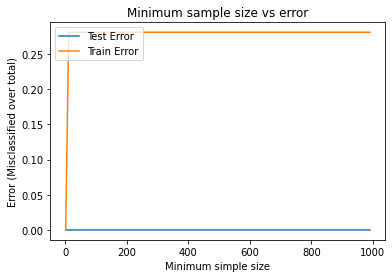

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

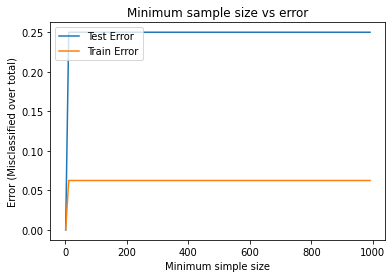

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

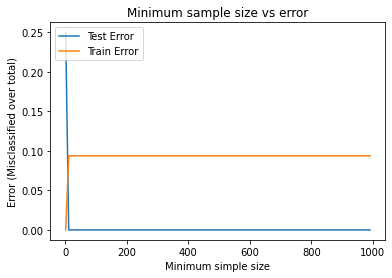

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

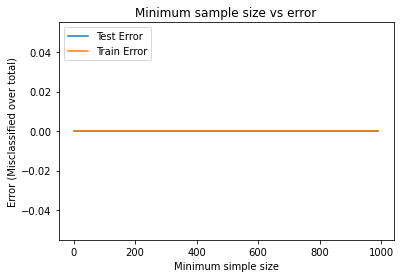

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

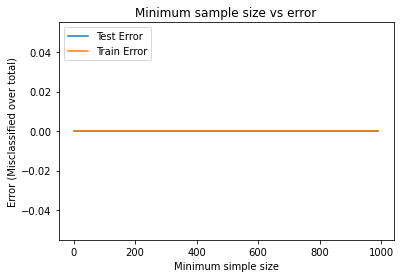

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

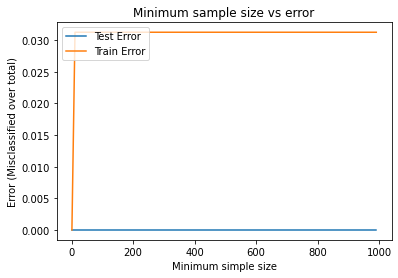

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

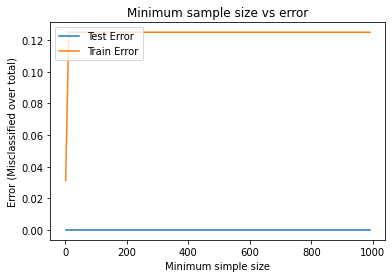

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

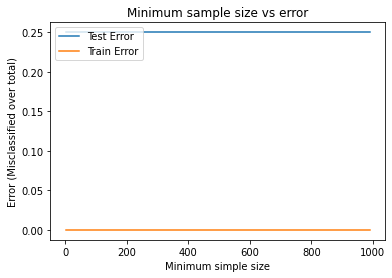

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

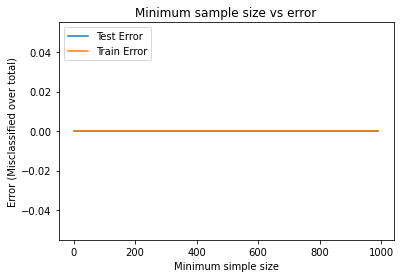

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

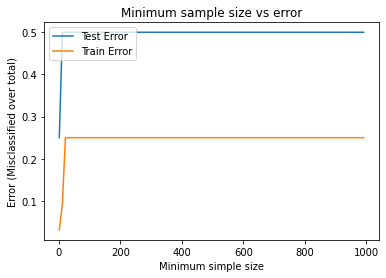

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

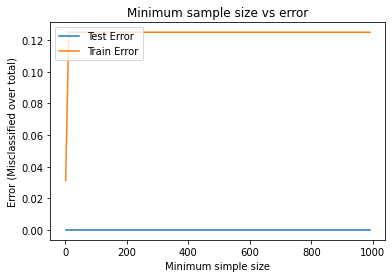

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

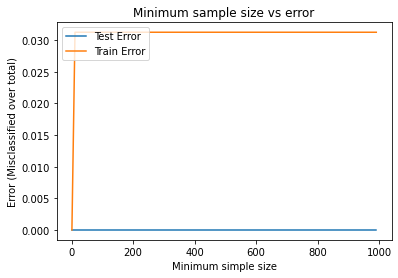

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

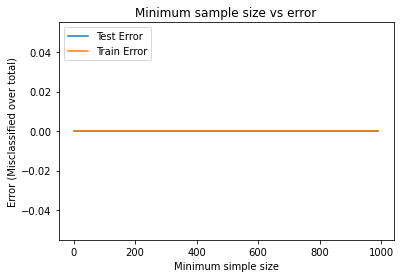

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

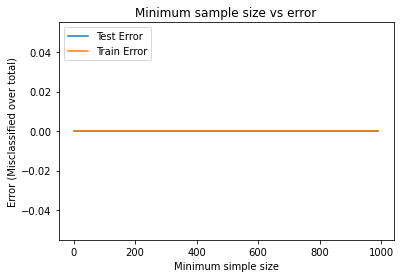

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

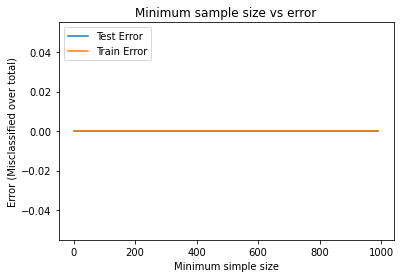

In [461]:
for color in colors:
    producetraintestgraphs(leavescolortraindict[f"{color}traindf"], leavescolortestdict[f"{color}testdf"])

It seems like the optimal sample size to truncate on is around 10 datapoints. Notice that while this did take a while to run, this analysis would not have been possible in reasonable time on a tree with multiple nodes as children. Now, we can train our final model to be used on the leaves and wood picture.

In [764]:
def getfeatures(colorsarray, ipos, jpos): # for one pixel
    features = [
        colorsarray[ipos-5][jpos-2], colorsarray[ipos-5][jpos-1], colorsarray[ipos-5][jpos], colorsarray[ipos-5][jpos+1], colorsarray[ipos-5][jpos+2],
        colorsarray[ipos-4][jpos-2], colorsarray[ipos-4][jpos-1], colorsarray[ipos-4][jpos], colorsarray[ipos-4][jpos+1], colorsarray[ipos-4][jpos+2],
        colorsarray[ipos-3][jpos-2], colorsarray[ipos-3][jpos-1], colorsarray[ipos-3][jpos], colorsarray[ipos-3][jpos+1], colorsarray[ipos-3][jpos+2],
        colorsarray[ipos-2][jpos-2], colorsarray[ipos-2][jpos-1], colorsarray[ipos-2][jpos], colorsarray[ipos-2][jpos+1], colorsarray[ipos-2][jpos+2],
        colorsarray[ipos-1][jpos-2], colorsarray[ipos-1][jpos-1], colorsarray[ipos-1][jpos], colorsarray[ipos-1][jpos+1], colorsarray[ipos-1][jpos+2],
        #colorsarray[ipos][jpos]
    ]
    return features

In [765]:
colors = ["brown", "red", "orange", "yellow", "pale light green", "deep light green", 
        "pale dark green", "deep dark green", "light blue", "blue", "gray", "white", "black"]

In [766]:
# check output of trees first and interpret it 
def onepixeloutput(colortreeheaddict, stringimarray, ipos, jpos):
    # get the pixel data
    pix1 = getfeatures(stringimarray, ipos, jpos)
    pix1 = pd.DataFrame(data=pix1)

    # make color arrays for each color
    colorarraysdict = {}
    for color in colors:
        colorarraysdict["{}array".format(color)] = pix1.where(pix1==color).replace(np.nan, -1).replace(color, 1).to_numpy().reshape(25,)

    outputdict = {}
    for color in colors: 
        # get output
        outputdict[color] = trackdatapoint(colortreeheaddict[f'{color}treehead'], colorarraysdict[f'{color}array'])
    
    return outputdict

In [767]:
def interpretoutput(outputdict):
    for col,num in outputdict.items():
        if num == 1:
            return col
    return "white" # default to white if all trees somehow come out negative

In [768]:
# trees
colortrees = {}
for color in colors: 
    # make color tree
    colortrees[f'{color}treehead'] = ClassificationTree(leavescolortraindict[f'{color}traindf'])
    buildtree(colortrees[f'{color}treehead'], 10)
    
f = open('treesfile.txt', 'w')
for j in range(300,601):
    for i in range(300,601):
        leafpixel = interpretoutput(onepixeloutput(colortrees, leavescolors, i,j))
        leavescolors[i][j] = leafpixel
        print(i,j, end="  ")
    print('\n')

300 300  301 300  302 300  303 300  304 300  305 300  306 300  307 300  308 300  309 300  310 300  311 300  312 300  313 300  314 300  315 300  316 300  317 300  318 300  319 300  320 300  321 300  322 300  323 300  324 300  325 300  326 300  327 300  328 300  329 300  330 300  331 300  332 300  333 300  334 300  335 300  336 300  337 300  338 300  339 300  340 300  341 300  342 300  343 300  344 300  345 300  346 300  347 300  348 300  349 300  350 300  351 300  352 300  353 300  354 300  355 300  356 300  357 300  358 300  359 300  360 300  361 300  362 300  363 300  364 300  365 300  366 300  367 300  368 300  369 300  370 300  371 300  372 300  373 300  374 300  375 300  376 300  377 300  378 300  379 300  380 300  381 300  382 300  383 300  384 300  385 300  386 300  387 300  388 300  389 300  390 300  391 300  392 300  393 300  394 300  395 300  396 300  397 300  398 300  399 300  400 300  401 300  402 300  403 300  404 300  405 300  406 300  407 300  408 300  409 300  410 300  4

KeyboardInterrupt: 

In [ ]:
# wood
colortrees = {}
for color in colors: 
    # make color tree
    colortrees[f'{color}treehead'] = ClassificationTree(leavescolortraindict[f'{color}traindf'])
    buildtree(colortrees[f'{color}treehead'], 10)
    

f = open('woodfile.txt', 'w')
for i in range(300,600):
    for j in range(300,600):
        woodpixel = interpretoutput(onepixeloutput(colortrees, woodcolors, i,j))
        woodcolors[i][j] = woodpixel
        print(i,j, end="  ")
    print('\n')

300 300  300 301  300 302  300 303  300 304  300 305  300 306  300 307  300 308  300 309  300 310  300 311  300 312  300 313  300 314  300 315  300 316  300 317  300 318  300 319  300 320  300 321  300 322  300 323  300 324  300 325  300 326  300 327  300 328  300 329  300 330  300 331  300 332  300 333  300 334  300 335  300 336  300 337  300 338  300 339  300 340  300 341  300 342  300 343  300 344  300 345  300 346  300 347  300 348  300 349  300 350  300 351  300 352  300 353  300 354  300 355  300 356  300 357  300 358  300 359  300 360  300 361  300 362  300 363  300 364  300 365  300 366  300 367  300 368  300 369  300 370  300 371  300 372  300 373  300 374  300 375  300 376  300 377  300 378  300 379  300 380  300 381  300 382  300 383  300 384  300 385  300 386  300 387  300 388  300 389  300 390  300 391  300 392  300 393  300 394  300 395  300 396  300 397  300 398  300 399  300 400  300 401  300 402  300 403  300 404  300 405  300 406  300 407  300 408  300 409  300 410  3

In [475]:
leavesfull = leavespicfloat.copy()
for i in range(300, 600):
    for j in range(300,600):
        leavesfull[i][j] = colortorgb(leavescolors[i][j])

In [469]:
woodfull = woodpicfloat.copy()
for i in range(300, 600):
    for j in range(300,600):
        woodfull[i][j] = colortorgb(woodcolors[i][j])

The final results:

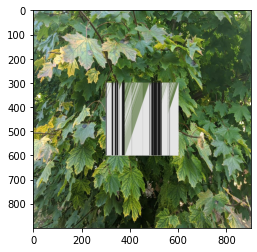

In [476]:
imgplot = plt.imshow(leavesfull, origin='upper')
plt.show()

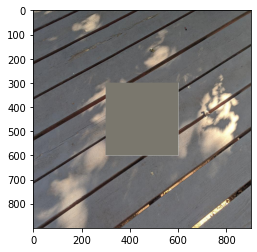

In [470]:
imgplot = plt.imshow(woodfull, origin='upper')
plt.show()

<img src="./new leaves.png" width="300" height="300">
<img src="./new wood.png" width="300" height="300">

Unfortunately, the results are very poor. This is possible due to a multitude of reasons: 
* First, the mapping for the RGB/HSV values to strings was done manually and was a very rough outline. Had I automated the process for categorizing the colors using some sort of unsupervised clustering algorithm, the preprocessing would have been more robust which might have translated to a better final product.
* Second, the input data I fed to the trees was a very small sample of the actual image, and this would explain the massive singular color square in the wood picture: its likely that while a couple of pixels might have been yellow/white on the far left edge of the center square, the majority of the wood picture is gray, and so that is likely all that the training data consisted of.
* The fact that I had to train and track the outputs of 12 trees definitely slowed my runtime down significantly, and was the reason why I could only have so much training data in the first place. A better methodology would have been to a fewer number of more relevant colors, or better yet tackle this as a regression problem and only worry about continuous red, green and blue values for each pixel. 

# Model 2: Neural Network

Once again, the first thing I did was make sure the center square was completely white.

In [478]:
leavespicwhite = leavespic.copy()
woodpicwhite = woodpic.copy()

for i in range(300, 601):
    for j in range(300, 601):
        leavespicwhite[i][j] = [255,255,255]
        woodpicwhite[i][j] = [255,255,255]

leavespicfloat = leavespicwhite/255
woodpicfloat = woodpicwhite/255

for i in range(300, 601):
    for j in range(300, 601):
        leavespicfloat[i][j] = np.array([1,1,1])
        woodpicfloat[i][j] = np.array([1,1,1])

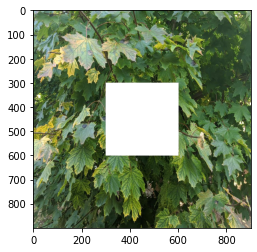

In [481]:
imgplot = plt.imshow(leavespicwhite, origin='upper')
plt.show()

I decided to treat this as a regression problem this time, using continuous RGB values instead of discrete labels. So, there isn't any more preprocessing to be done: numpy already has these color vectors to use.

My approach to this problem is similar, at a high level, to the tree solution. I can feed in an array of pixels to a model and output what one pixel is going to be at a time. The choice of this input array also would determine the type of neural network I choose. Again, I can paint in this image from left to right, top to bottom, which would allow for bootstrapping, as newly generated colors would depend on previously generated outputs. While there are risks involved with bootstrapping, it might not be as big of a problem as it was with the trees, as neural networks can learn more complicated nonlinear features between the feature pixels, and this could mitigate those risks. All of my data would also need to be harvested similarly, to the left of the training output pixels. There is an abundance of pixels in the images provided themselves, and so data augmentation and sourcing new pictures due to lack of sufficient training/testing data is not a concern.

Choosing a large input array would necessitate that I use filters and a CNN, as using only dense layers would essentially weight every feature pixel the same, which should definitely not be the case: a pixel 50 or 100 pixels away is much less likely to influence the color of the output pixel than one 3 to 5 pixels away. Additionally, passing in such a large array into the model might take too long. Choosing a smaller array, like the 5x5 that the tree model used, would allow us to flatten and pass the feature pixels into the model reasonably: every pixel in this array is within sufficient distance of the output pixel such that we can consider all of them equally. 

For the choice of architecture for my neural network, dealing with image data usually suggests that multiple hidden layers would work better than one. The network processses different visual features of the image with each new layer: branches, leaves, finer details, etc. However, given the choice of input and output space, we aren't learning any visual features of the input at all, as a 5x5 array of pixels does not contain significant underlying information about the larger picture. Therefore, one hidden layer is most likely going to be sufficient. Successive layers may only add to the runtime without any significant improvement in visual quality. To choose how many nodes are going to be in this hidden layer, I can use the training/testing loss to see which number would yield the best results and prevent overfitting the best. A highly overfit network would not be able to generalize well to the white pixels, so it is important that the effect this parameter has on the loss is analyzed. It might be more of a concern the larger the hidden layer and the more complex the model in general becomes.

The activation functions for these two layers, the hidden and output layer, should be standard. For the hidden layer, I can use the ReLU function, and for the output, I can use the sigmoid function. The sigmoid function standardizes the outputs of the hidden layer between 0 and 1, which can both be interpreted as the probability of each color R,G,B occurring, and the amount of each to be used in the output pixel.

The training algorithm I use for my network is backpropagation via SGD, where I pick one random datapoint at a time and routinely update weight matrices between layers to converge onto a solution. The loss here would just be the average squared distance between the correct RGB value for a 25x3 array and the output of my network. This way, the smaller the testing error is, the closer my network is generating colors to the actual testing outputs. Naturally, this definition of loss should translate directly to the quality of visual results. 

When looking at the data, it becomes clear that the dataset is not just 2 dimensional, but 3 dimensional now (number of datapoints, the 25 features, and the 3 RGB values). I can either create three different networks, one to process each color seperately, or create a network capable of handling this new input dimension. The former is cumbersome and would require a lot of extra copying and converting between dataframes: the second option is more convenient and more efficient. So, my input space would be datapoints with dimensions 25x3, and my output space would be one 3 dimensional vector, meaning my model would need to process a 3 dimensional mx26x3 array at once, where m is the number of training datapoints. 

In [668]:
leavescolorsdfnn = pd.DataFrame(columns=[f'x{i}' for i in range(1,26)]+['y'])
woodcolorsdfnn = pd.DataFrame(columns=[f'x{i}' for i in range(1,26)]+['y'])

In [817]:
def createdata(colorsarray, targetdf):
    for i in range(6, 900, 10):
        for j in range(2, 897, 10):
            if (i<600 and i>300) or (j<600 and j>300): continue
            targetdf.loc[len(targetdf.index)] = [
                colorsarray[i-5][j-2], colorsarray[i-5][j-1], colorsarray[i-5][j], colorsarray[i-5][j+1], colorsarray[i-5][j+2],
                colorsarray[i-4][j-2], colorsarray[i-4][j-1], colorsarray[i-4][j], colorsarray[i-4][j+1], colorsarray[i-4][j+2],
                colorsarray[i-3][j-2], colorsarray[i-3][j-1], colorsarray[i-3][j], colorsarray[i-3][j+1], colorsarray[i-3][j+2],
                colorsarray[i-2][j-2], colorsarray[i-2][j-1], colorsarray[i-2][j], colorsarray[i-2][j+1], colorsarray[i-2][j+2],
                colorsarray[i-1][j-2], colorsarray[i-1][j-1], colorsarray[i-1][j], colorsarray[i-1][j+1], colorsarray[i-1][j+2],
                colorsarray[i][j]
                ]
            # print(i,j)

Much like the tree model, using every single pixel in the datasets is not reasonable. Instead, we use every 10th pixel in both the x and y directions to get a representative sample of the data. Unlike the tree model, we can use a lot more datapoints here (every 10th vs 100th) as my code is optimized and I'm expecting my neural network to run much faster than the ensemble of 12 trees.

In [818]:
createdata(leavespicfloat, leavescolorsdfnn)
createdata(woodpicfloat, woodcolorsdfnn)

In [773]:
leavescolorsnpnn = np.zeros((leavescolorsdfnn.shape[0],26,3))
woodcolorsnpnn = np.zeros((woodcolorsdfnn.shape[0],26,3))

In [774]:
# transforming pandas dataframe into np tensors
for i in range(leavescolorsdfnn.shape[0]):
    for j in range(leavescolorsdfnn.shape[1]):
        leavescolorsnpnn[i][j] = leavescolorsdfnn.iloc[i,j]

for i in range(woodcolorsdfnn.shape[0]):
    for j in range(woodcolorsdfnn.shape[1]):
        woodcolorsnpnn[i][j] = woodcolorsdfnn.iloc[i,j]

In [775]:
def getfeatures(imagearray, ipos, jpos): # for one pixel
    return np.array([
        imagearray[ipos-5][jpos-2], imagearray[ipos-5][jpos-1], imagearray[ipos-5][jpos], imagearray[ipos-5][jpos+1], imagearray[ipos-5][jpos+2],
        imagearray[ipos-4][jpos-2], imagearray[ipos-4][jpos-1], imagearray[ipos-4][jpos], imagearray[ipos-4][jpos+1], imagearray[ipos-4][jpos+2],
        imagearray[ipos-3][jpos-2], imagearray[ipos-3][jpos-1], imagearray[ipos-3][jpos], imagearray[ipos-3][jpos+1], imagearray[ipos-3][jpos+2],
        imagearray[ipos-2][jpos-2], imagearray[ipos-2][jpos-1], imagearray[ipos-2][jpos], imagearray[ipos-2][jpos+1], imagearray[ipos-2][jpos+2],
        imagearray[ipos-1][jpos-2], imagearray[ipos-1][jpos-1], imagearray[ipos-1][jpos], imagearray[ipos-1][jpos+1], imagearray[ipos-1][jpos+2],
        imagearray[ipos][jpos]
    ])

In [517]:
def createWmatrices(k):
    W1 = np.random.normal(loc=0, scale=0.01, size=(k,25))
    W2 = np.random.normal(loc=0, scale=0.01, size=(1,k))
    return W1, W2

In [806]:
def train1hd(dfnp, testnp, W1, W2, alpha, iters, k):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    def sigmoidderiv(x):
        return np.exp(x) / (np.exp(x)+1)**2

    for i in range(iters):
        r = np.random.randint(0,dfnp.shape[0]) # SGD
        d = dfnp[r,0:-1] # 25x3
        y = dfnp[r,-1] # 1x3

        # forward pass
        x1 = W1@d # kx3 (basically ReLU, input can't be negative anyway)
        x2 = sigmoid((W2@x1)[0]) # 1x3

        # backward pass
        delta2 = 2*(x2-y)*sigmoidderiv((W2@x1)[0]) # 1x3
        delta2r = np.reshape(delta2, (1,3))
        x1r = np.reshape(x1, (k,3)) 
        dLdw2 = delta2r@x1r.T # 1xk 


        delta1 = (W2.T@delta2r) # kx1*1x3 = kx3
        delta1r = np.reshape(delta1, (k,3))
        dr = np.reshape(d, (25,3))
        dLdw1 = delta1r@dr.T # kx3*3x25 = kx25

        # update step
        W1 -= alpha*dLdw1
        W2 -= alpha*dLdw2
        # print(W2)
    
    loss = 0
    for datapoint in testnp:
        # print(W2@(sigmoid(W1@datapoint[0:-1])))
        loss += (np.linalg.norm(datapoint[-1]-(sigmoid(W2@(W1@datapoint[0:-1])))))**2
    loss /= testnp.shape[0]
    return loss

In [808]:
def trainwithouttest1hd(dfnp, W1, W2, alpha, iters, k):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    def sigmoidderiv(x):
        return np.exp(x) / (np.exp(x)+1)**2

    for i in range(iters):
        r = np.random.randint(0,dfnp.shape[0]) # SGD
        d = dfnp[r,0:-1] # 25x3
        y = dfnp[r,-1] # 1x3

        # forward pass
        x1 = W1@d # kx3 (basically ReLU, input can't be negative anyway)
        x2 = sigmoid((W2@x1)[0]) # 1x3

        # backward pass
        delta2 = 2*(x2-y)*sigmoidderiv((W2@x1)[0]) # 1x3
        delta2r = np.reshape(delta2, (1,3))
        x1r = np.reshape(x1, (k,3)) 
        dLdw2 = delta2r@x1r.T # 1xk 


        delta1 = (W2.T@delta2r) # kx1*1x3 = kx3
        delta1r = np.reshape(delta1, (k,3))
        dr = np.reshape(d, (25,3))
        dLdw1 = delta1r@dr.T # kx3*3x25 = kx25

        # update step
        W1 -= alpha*dLdw1
        W2 -= alpha*dLdw2
        # print(W2)
    
    return W1, W2

In [809]:
def producelosses(df, testdf, k, alpha, iters):
    w1, w2 = createWmatrices(k)

    L = train1hd(df, testdf, w1, w2, alpha, iters, k)
    # print(round(L,2), end=' ')
    return L

In [822]:
def generategraph(alpha, iters):
    ks = np.arange(1,31,1)
    trainlosses = []
    testlosses = []

    df,testdf = traintestsplit(leavescolorsdfnn)

    trtemp = np.zeros((df.shape[0], 26, 3))
    tetemp = np.zeros((testdf.shape[0], 26, 3))

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            trtemp[i][j] = df.iloc[i,j]
    
    for i in range(testdf.shape[0]):
        for j in range(testdf.shape[1]):
            tetemp[i][j] = testdf.iloc[i,j]

    for k in ks:
        # print(k)
        # TrainL = producelosses(trtemp, trtemp, k, alpha, iters)
        # trainlosses.append(TrainL)
        TestL = producelosses(trtemp, tetemp, k, alpha, iters)
        testlosses.append(TestL)
        # print()
    
    plt.figure()
    plt.plot(ks, testlosses, label='Test Error')
    # plt.plot(ks, trainlosses, label='Train Error')
    plt.title("k vs Loss")
    plt.xlabel("k (Hidden nodes)")
    plt.ylabel("Loss")
    # plt.legend(loc="upper left")
    plt.show()

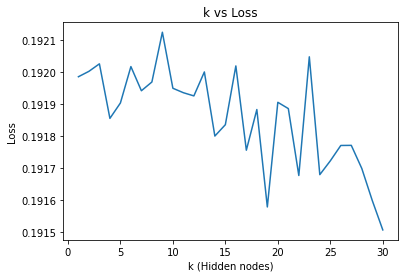

In [824]:
generategraph(0.001, 2000)

It seems like 15 nodes should be a good number for the hidden layer.

In [797]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def onepixeloutput(W1, W2, imagearray, ipos, jpos):
    # get the pixel data
    pix1 = getfeatures(imagearray, ipos, jpos) # should be 26x3
    
    return sigmoid((W2@(W1@pix1[0:-1])))[0]

In [798]:
def paint(imagearray, W1, W2):
    for i in range(300, 601):
        for j in range(300, 601):
            imagearray[i][j] = onepixeloutput(W1, W2, imagearray, i, j)

In [812]:
L1, L2 = createWmatrices(15)
L1, L2 = trainwithouttest1hd(leavescolorsnpnn, L1, L2, 0.001, 2000, 15)

W1, W2 = createWmatrices(15)
W1, W2 = trainwithouttest1hd(woodcolorsnpnn, W1, W2, 0.001, 2000, 15)

In [813]:
leavesfullnn = leavespicfloat.copy()
woodfullnn = woodpicfloat.copy()

paint(leavesfullnn, L1, L2)
paint(woodfullnn, W1, W2)

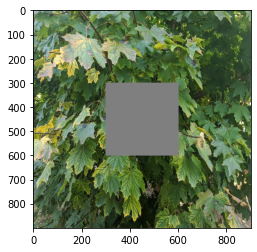

In [814]:
imgplot = plt.imshow(leavesfullnn, origin='upper')
plt.show()

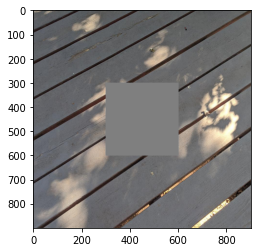

In [815]:
imgplot = plt.imshow(woodfullnn, origin='upper')
plt.show()

### Final thoughts and assessment:

It turns out that my neural network definitively performed worse than the 12 trees did, despite having much faster runtime and a lot more data to train on. This is most likely a problem with the architecture of my network and not the actual data: had I tweaked the activation functions and possibly tested deeper layers, the results may have been better. The tree solution filled out the images better because it was able to classify the colors properly using discrete labels. For the network, it was not able to differentiate between colors well enough to produce a good output. Besides simply viewing the final output visually, future tweaks to be made for the model could include checking exactly what each part of each model is outputting at each step, and see if it aligns with our expectations. 

# Bonus 2: Developed Inpainting Solutions

For this bonus, I used the [Lama Cleaner](https://github.com/Sanster/lama-cleaner) app to test out some developed inpainting models. The two I tried were the lama model and the fcf model.

This was my attempt using the LaMa Model:

<img src="./Leaves_Masked_cleanup (1).jpg" width="300" height="300">
<img src="./Wood_Masked_cleanup (2).jpg" width="300" height="300">

And these were the results using the FcF model:

<img src="./Leaves_Masked_cleanup (3).jpg" width="300" height="300">
<img src="./Wood_Masked_cleanup.jpg" width="300" height="300">

Both have very impressive results compared to my own, but the FcF model looks especially great. For a simple and monotone image, both models performed similarly, but for a complicated image like the leaves, FcF ws superior. One significant improvement between these models and my own is the runtime: instead of filling in the image pixel by pixel, these methods work on a whole region of the picture at once and are heavily optimized, leading to me getting these results in a fraction of a second. It's interesting how if you try filling in the entire square at once, you get worse results when compared to filling in pieces of the square at a time.

The LaMa model was proposed in a [paper](https://arxiv.org/pdf/2109.07161.pdf) from 2021, and is a neural network developed using fast Fourier convolutions. From class, this most likely has to do with the fact that a convolution operation can be improved in efficiency using the Fast Fourier Transform algorithm. This, along with some other novel ideas, makes for a pretty good model for inpainting. One downside I can see is that for much larger holes in an image, LaMa resorts to blurring and smearing the more it is unsure of the output.

FcF was proposed in a [paper](https://arxiv.org/pdf/2208.03382.pdf) earlier this year, and also uses the fast Fourier convolutions, in conjunction with a special type of generator network (namely, a coarse-to-fine GAN network). This allows for results that generalize better to complex structures even with limited surrounding data, as was the case with the leaves image.

# Bonus 3: Professor Cowan's dog on her birthday

<img src="./dogbday.png" width="300" height="300">
